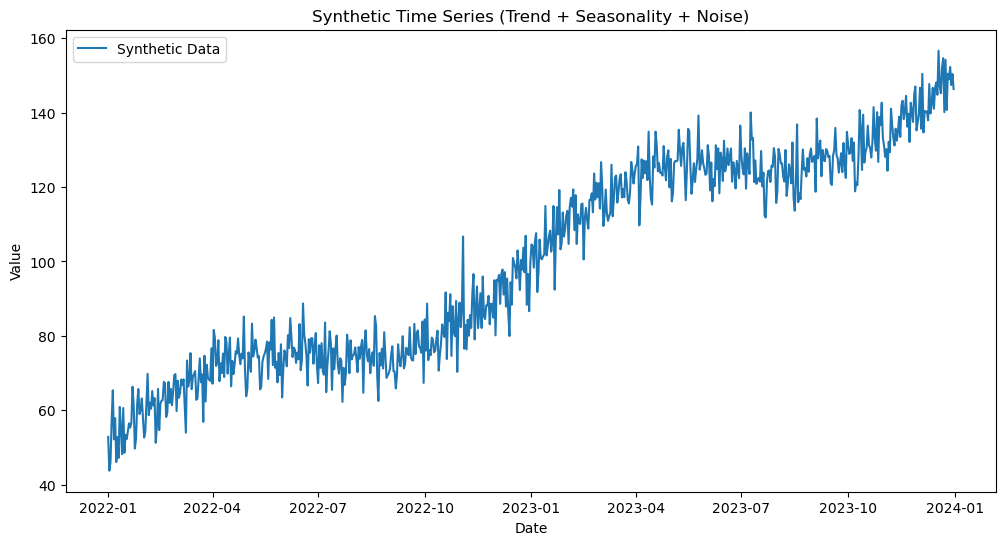

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Create a daily data range (2022-01-01 - 2023-12-31)
date_range = pd.date_range(start="2022-01-01", end="2023-12-31", freq="D")

# 2. Add components
trend = np.linspace(50, 150, len(date_range))                       # upward trend
seasonality = 10 * np.sin(2 * np.pi * date_range.dayofyear / 365)   # yearly seasonality\
noise = np.random.normal(0, 5, len(date_range))

# 3. Combine into one series
values = trend + seasonality + noise

# 4. Create DataFrame
df = pd.DataFrame({"Date": date_range, "Value": values})
df.set_index("Date", inplace=True)

# 5. Plot it
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Value"], label="Synthetic Data")
plt.title("Synthetic Time Series (Trend + Seasonality + Noise)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

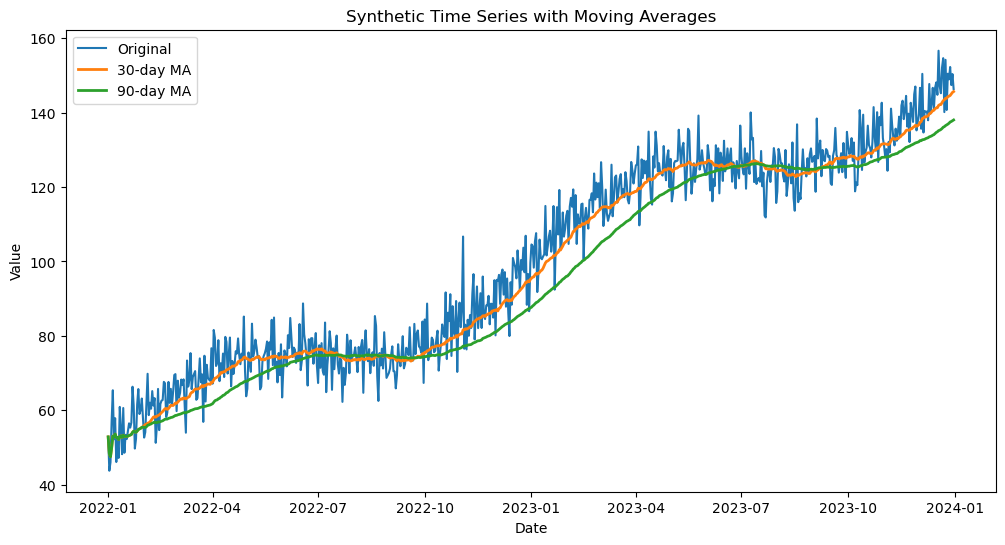

In [3]:
df["MA_30"] = df["Value"].rolling(window=30, min_periods=1).mean()
df["MA_90"] = df["Value"].rolling(window=90, min_periods=1).mean()

plt.figure(figsize=(12,6))
plt.plot(df.index, df["Value"], label="Original")
plt.plot(df.index, df["MA_30"], label="30-day MA", linewidth=2)
plt.plot(df.index, df["MA_90"], label="90-day MA", linewidth=2)
plt.title("Synthetic Time Series with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

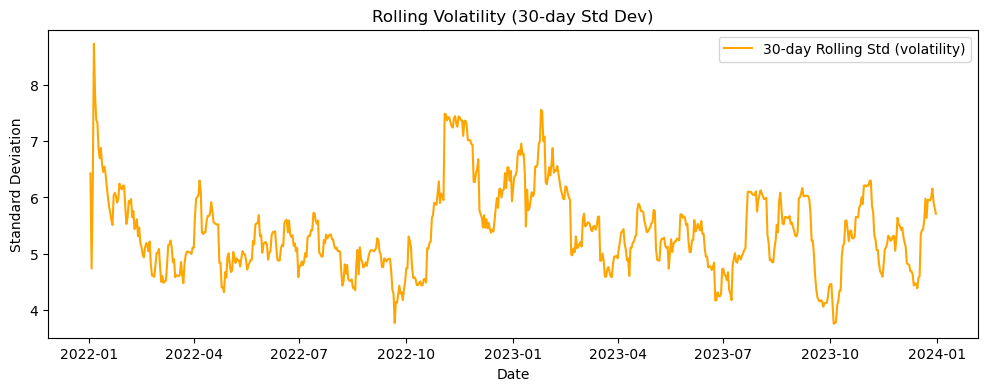

In [5]:
# Calculate 30-day rolling standard deviation (volatility)
df["Vol_30"] = df["Value"].rolling(window=30, min_periods=1).std()

# Plot rolling volatility
plt.figure(figsize=(12,4))
plt.plot(df.index, df["Vol_30"], label="30-day Rolling Std (volatility)", color="orange")
plt.title("Rolling Volatility (30-day Std Dev)")
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.legend()
plt.show()

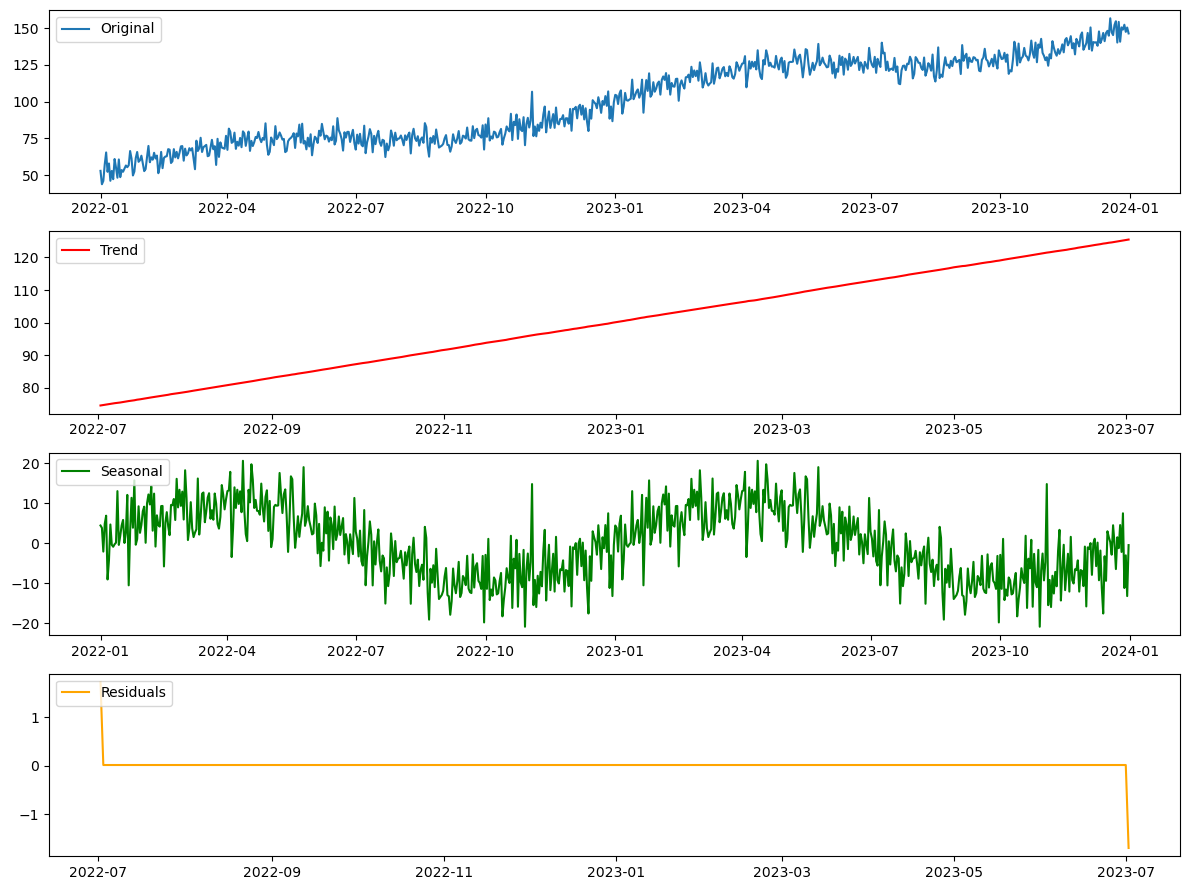

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (yearly seasonality - period=365)
decomposition = seasonal_decompose(df["Value"], model="additive", period=365)

# Plot all components
plt.figure(figsize=(12,9))

plt.subplot(411)
plt.plot(df["Value"], label="Original")
plt.legend(loc="upper left")

plt.subplot(412)
plt.plot(decomposition.trend, label="Trend", color="red")
plt.legend(loc="upper left")

plt.subplot(413)
plt.plot(decomposition.seasonal, label="Seasonal", color="green")
plt.legend(loc="upper left")

plt.subplot(414)
plt.plot(decomposition.resid, label="Residuals", color="orange")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

# Run Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df["Value"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

# Interpretation
if adf_result[1] < 0.05:
    print("Series is stationary (reject null hypothesis)")
else:
    print("Series is NOT stationary (needs differencing)")

ADF Statistic: -0.26813414537870944
p-value: 0.9298978080617162
Critical Values: {'1%': -3.4395418285955563, '5%': -2.865596454500293, '10%': -2.5689301318958955}
Series is NOT stationary (needs differencing)


ADF Statistic (Differenced): -11.143508664591417
p-value (Differenced): 3.0663838231491935e-20
Differenced series is stationary


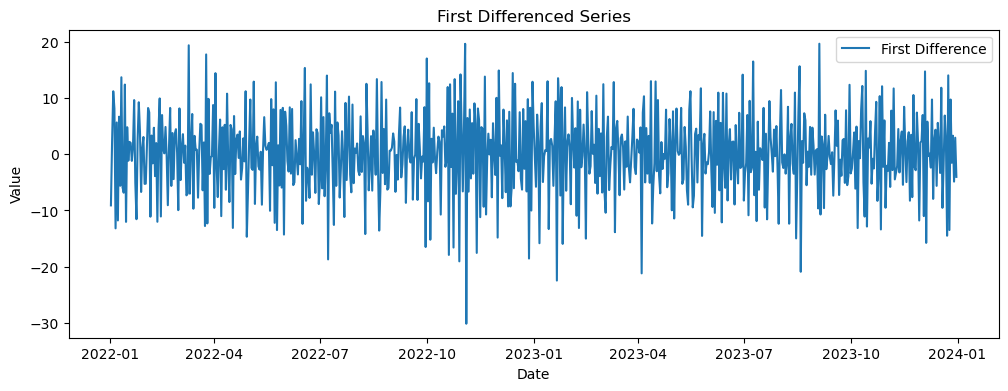

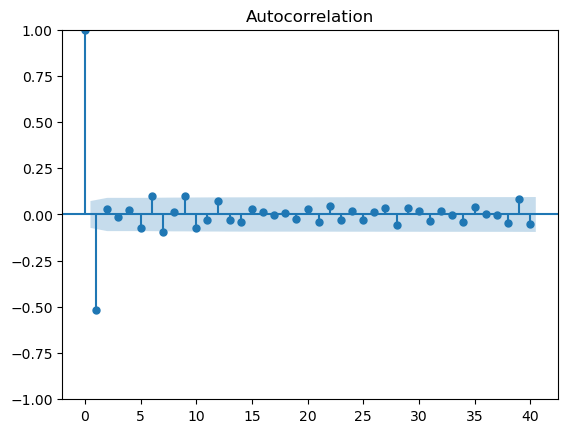

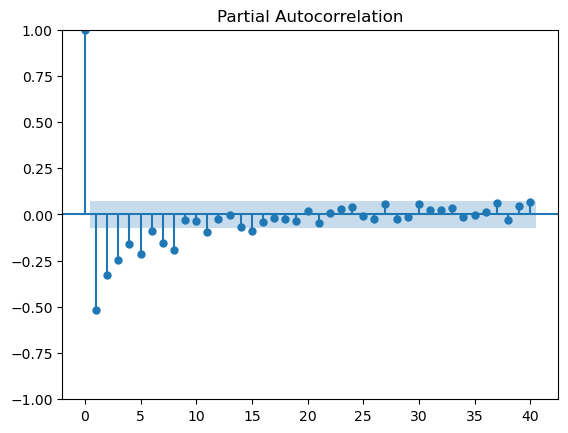

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# First difference (remove trend)
df["Diff1"] = df["Value"].diff()

# Drop missing values (first row becomes NaN)
diff1 =df["Diff1"].dropna()

# ADF test again  on differenced series 
adf_diff = adfuller(diff1)
print("ADF Statistic (Differenced):", adf_diff[0])
print("p-value (Differenced):", adf_diff[1])

if adf_diff[1] < 0.05:
    print("Differenced series is stationary")
else:
    print("Still not stationary")

# Plot the differenced series
plt.figure(figsize=(12,4))
plt.plot(diff1, label="First Difference")
plt.title("First Differenced Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Plot ACF and PACF
plot_acf(diff1, lags=40)
plt.show()

plot_pacf(diff1, lags=40, method="ywm")
plt.show()

/home/cyber/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cyber/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cyber/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 10.286673582720077
RMSE: 12.409298253704709
MAPE: 7.213324404541031


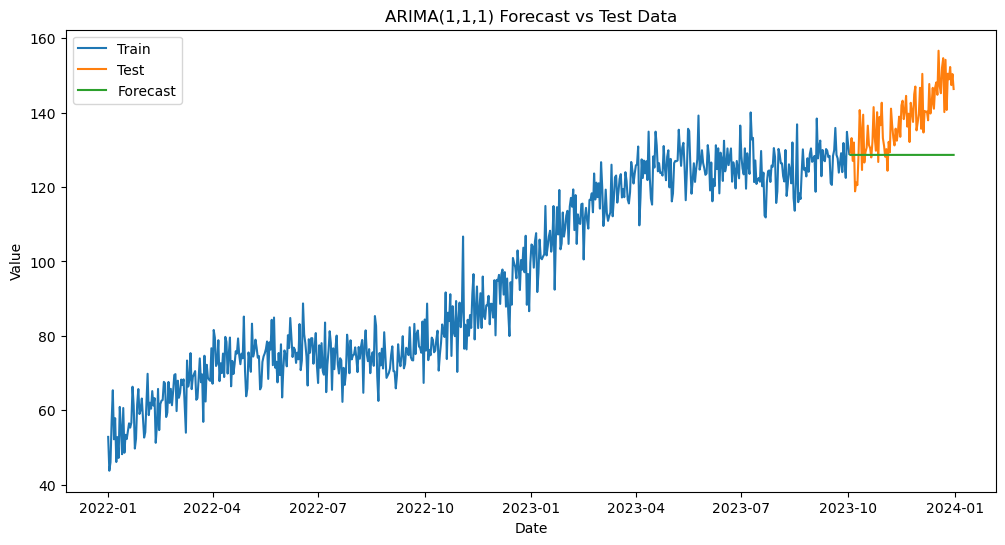

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split: last 90 days as test set
test_size = 90
train = df["Value"][:-test_size]
test = df["Value"][-test_size:]

# Fit ARIMA(1,1,1)
model = ARIMA(train, order=(1,1,1))
fitted = model.fit()

# Forecast same lenght as test set
forecast = fitted.forecast(steps=len(test))

# Evaluate performance
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print('MAE:', mae)
print("RMSE:", rmse)
print("MAPE:", mape)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.title("ARIMA(1,1,1) Forecast vs Test Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

/home/cyber/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cyber/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cyber/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


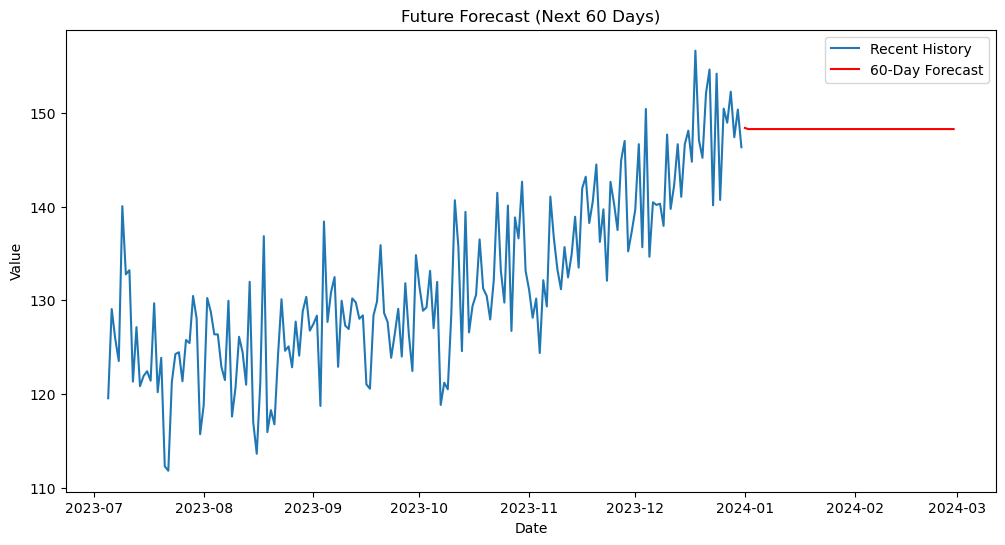

In [16]:
# Refit ARIMA on full dataset
full_model = ARIMA(df["Value"], order=(1,1,1))
full_fit = full_model.fit()

# Forecast the next 60 days
n_future = 60
future_forecast = full_fit.forecast(steps=n_future)

# Create future date index
future_index = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_future, freq="D")
future_forecast = pd.Series(future_forecast.values, index=future_index, name="Forecast")

# Plot last 180 days + forecast
plt.figure(figsize=(12,6))
plt.plot(df.index[-180:], df["Value"][-180:], label="Recent History")
plt.plot(future_forecast.index, future_forecast, label="60-Day Forecast", color="red")
plt.title("Future Forecast (Next 60 Days)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()